# EEG Machine Learning Pipeline

## TO DO - To Review

Projects:
- Pickle: https://www.perplexity.ai/search/in-a-jupyter-notebook-i-have-c-0LbAAH9ITFGfcPYaWlrt6Q

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

# Imports & Utilities

In [1]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle

import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

# Random Forest
from sklearn.ensemble import RandomForestClassifier



In [2]:
# Utility function to establish relative paths for a given folder
def get_folder_path(folder_name, data_folder='Data'):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
    return folder_path

# Utility function to create a new folder path, if not exists
def make_folder_path(folder_name, data_folder='Data', exists_ok=True):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if os.path.exists(folder_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {folder_path}")
    else:
        os.makedirs(folder_path)
    return folder_path

 # Utility function to extend an existing folder path with a subfolder
def extend_folder_path(base_folder, subfolder, exists_ok=True):
    if not os.path.isdir(base_folder):
        raise FileNotFoundError(f'Parent directory not found: {base_folder}')
    extended_path = os.path.join(base_folder, subfolder)
    if os.path.exists(extended_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {extended_path}")
    else:
        os.makedirs(extended_path)
    return extended_path

# Utility function to check for the existence of a file in a given folder
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path


# Classes & Functions

## Binary Classification Models

In [3]:
# Function to Display The Model Fit Results

def print_search_results(search, duration):
    print('------- Search Results --------')
    all_search_results = pd.DataFrame(search.cv_results_)
    print(f"Score: {search.best_score_:.4f}. Mean: {np.mean(all_search_results['mean_test_score']):.4f} and STD {np.std(all_search_results['mean_test_score']):.4f}")
    print(f'Search Took: {duration:.2f} seconds')
    print(f"Best Parameters: {search.best_params_}")
    top_n = 10
    print(f"Top {top_n} out of {len(all_search_results)} combinations:")
    display(all_search_results[['rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']].sort_values(by='rank_test_score').head(top_n))


In [4]:
# Function to Present the Evaluation Metrics for a Classification Model

def classification_metrics(for_Model, X_test, y_test, y_pred):
    plt.style.use('default')

    # Calculate Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Print various metrics
    print(f'Accuracy: {metrics.accuracy_score(y_true=y_test, y_pred=y_pred):.4f}')
    print(f'Precision: {metrics.precision_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Recall: {metrics.recall_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'F1 Score {metrics.f1_score(y_true=y_test, y_pred=y_pred, pos_label=1):.4f}')
    print(f'Specificity: {tn / (tn + fp):.4f}')
    print(f'Hamming Loss {metrics.hamming_loss(y_true=y_test, y_pred=y_pred):.4f}')


    # Plot Confusion Matrix
    class_labels = for_Model.classes_
    fig, ax = plt.subplots(figsize=(12,4))
    ax.set_title('Confusion Matrix')
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(ax=ax)
    plt.show

    y_probabilities = for_Model.predict_proba(X_test)[:, 1]
    roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=y_probabilities)
    print(f'ROC-AUC Score {roc_auc_score:.4f}')
    gini_score = 2 * roc_auc_score - 1
    print(f'Gini Index: {gini_score:.4f}')

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(6,4))
    ax.set_title('ROC Curve')
    roc_display = RocCurveDisplay.from_estimator(for_Model, X_test, y_test, ax=ax, pos_label=1)
    plt.show()

    plt.style.use('ggplot')

# Setup & Features Load

In [5]:
# ML Pipeline Run Define & Setup
#

# -----------------------------------------------------------------------
# Study Details
# study_name = 'IOWA_Rest'
# dataset_ref = 'ds004584-1.0.0'
# eeg_run_id = '20250618'
study_name = 'UNM_Oddball'
dataset_ref = 'ds003490-1.1.0'
eeg_run_id = '20250618'

# Run/Test Mode
test_mode = False

# Execution Parameters
ml_params = {'models': 'none'
            }
# -----------------------------------------------------------------------

# Get existing study details, if exists
study_folder_path = get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
# dataset_path = study_info_df.loc[0, 'dataset_path']
eeg_processing_results_path = study_info_df.loc[0, 'eeg_processing_results_path']
ml_training_results_path = study_info_df.loc[0, 'ml_training_results_path']

# Establish a new ML Training Run
current_date = datetime.now().strftime('%Y%m%d')
ml_run_id = f'ML_Training_{dataset_ref}_{current_date}'
ml_training_run_path = extend_folder_path(ml_training_results_path, ml_run_id, exists_ok=False)

# Create run df and save
ml_run_params_df = pd.DataFrame({
    'ml_run_id': [ml_run_id],
    'study_name': [study_name],
    'dataset_ref': [dataset_ref],
    'ml_params': [ml_params]
})
ml_run_params_df.to_pickle(ml_training_run_path + '/ml_run_params_df.pkl', compression='zip')

# Get the EEG features
eeg_run_id = eeg_run_id = f'EEG_Processing_{dataset_ref}_{eeg_run_id}'
eeg_processing_run_path = os.path.join(eeg_processing_results_path, eeg_run_id)
eeg_results_features_superset_df = pd.read_pickle(eeg_processing_run_path + '/eeg_results_features_superset_df.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
else:
    VERBOSE = False

del current_date, eeg_processing_run_path, eeg_processing_results_path, eeg_run_id, ml_training_results_path

# Features Inspection, Cleaning & Reduction

In [6]:
study_features_cleaned_df = eeg_results_features_superset_df.copy()

# Drop some channels
# TODO: Should this be in the EEG pipeline so that uniform features are produced?
# Drop all columns with channel number greater than 63 .... ?? or delete row 63 as perhaps an error
# TODO: This actually reduces the AUC!?
cols_to_drop = [col for col in study_features_cleaned_df.columns if 'chn_' in col and int(col.split('_')[1]) > 63]
study_features_cleaned_df.drop(columns=cols_to_drop, inplace=True)

# Drop all columns containing 'error' or 'r_squared'
# TODO: This doesn't make much difference to the predictions
cols_to_drop = [col for col in study_features_cleaned_df.columns if 'error' in col or 'r_squared' in col]
study_features_cleaned_df.drop(columns=cols_to_drop, inplace=True)

# Drop all columns containing 'cf', 'bw', or 'pw'
# TODO: This significantly reduces recall and AUC, false negatives and false positives are increased
# cols_to_drop = [col for col in study_features_cleaned_df.columns if any(x in col for x in ['cf', 'bw', 'pw'])]
# study_features_cleaned_df.drop(columns=cols_to_drop, inplace=True)

# TODO: Dropping all peiodic other than CF doesn't make much difference!!
# cols_to_drop = [col for col in study_features_cleaned_df.columns if any(x in col for x in ['bw', 'pw'])]
# study_features_cleaned_df.drop(columns=cols_to_drop, inplace=True)

# Drop all columns containing 'offset' or 'exponent'
# TODO: This reduces AUC and false positives are increased
# cols_to_drop = [col for col in study_features_cleaned_df.columns if 'offset' in col or 'exponent' in col]
# study_features_cleaned_df.drop(columns=cols_to_drop, inplace=True)

# Drop features
# # TODO: Increases false positives ....
# dropped_variables = ['gender']
# study_features_cleaned_df.drop(dropped_variables, axis=1, inplace=True)

# # TODO: Increases false negatives, redices recall. ...... is this to be expected given the PD in age, look at control group ages?
# dropped_variables = ['age']
# study_features_cleaned_df.drop(dropped_variables, axis=1, inplace=True)

# Drop features
dropped_variables = ['subject_id']
study_features_cleaned_df.drop(dropped_variables, axis=1, inplace=True)

# Before and After
print(eeg_results_features_superset_df.shape)
print(study_features_cleaned_df.shape)

(50, 2282)
(50, 2051)


# Data Split ...

In [7]:
# Separate features (X) and target variable (y)
targetName = "pd"
featureNames = study_features_cleaned_df.columns[study_features_cleaned_df.columns != targetName]

X = study_features_cleaned_df[featureNames]
y = study_features_cleaned_df[targetName]

# Split of training and testing data, 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

del targetName, featureNames, X, y

# Transforms  ....

In [8]:
# Establish a transformation for categorical and numerical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object', 'bool']).columns

print(f'Numerics {len(numerical_features)} \n', numerical_features)
print(f'Categoricals {len(categorical_features)} \n', categorical_features)

transformations = [
    ('cat', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'), categorical_features),
    # ('num', RobustScaler(), numerical_features) - more false positives
    # ('num', StandardScaler(), numerical_features) - AUC reduced
    # ('num', MinMaxScaler(), numerical_features) -more false positives & AUC reduced
    ('num', 'passthrough', numerical_features)
]

# Add to pipeline, and later add other actions such as dropping rows, imputing etc etc
data_prep_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    ('col_transform', ColumnTransformer(transformers=transformations))
])
data_prep_pipeline.fit(X_train)

Numerics 2049 
 Index(['age', 'chn_0_offset', 'chn_0_exponent', 'chn_0_cf_0', 'chn_0_pw_0',
       'chn_0_bw_0', 'chn_0_cf_1', 'chn_0_pw_1', 'chn_0_bw_1', 'chn_0_cf_2',
       ...
       'chn_63_bw_6', 'chn_63_cf_7', 'chn_63_pw_7', 'chn_63_bw_7',
       'chn_63_cf_8', 'chn_63_pw_8', 'chn_63_bw_8', 'chn_63_cf_9',
       'chn_63_pw_9', 'chn_63_bw_9'],
      dtype='object', length=2049)
Categoricals 1 
 Index(['gender'], dtype='object')


,steps,"[('col_transform', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [9]:
# Transform the separate datasets
X_train_transformed = data_prep_pipeline.transform(X_train)
X_test_transformed = data_prep_pipeline.transform(X_test)

In [10]:
display(f'Original: {eeg_results_features_superset_df.shape}')
display(f'Cleaned: {study_features_cleaned_df.shape}')

display(f'X_Train: {X_train_transformed.shape}')
display(f'X_Test: {X_test_transformed.shape}')
display(data_prep_pipeline.get_feature_names_out())
feature_names = data_prep_pipeline.get_feature_names_out()

'Original: (50, 2282)'

'Cleaned: (50, 2051)'

'X_Train: (40, 2050)'

'X_Test: (10, 2050)'

array(['cat__gender_Male', 'num__age', 'num__chn_0_offset', ...,
       'num__chn_63_cf_9', 'num__chn_63_pw_9', 'num__chn_63_bw_9'],
      dtype=object)

## Decision Tree - Random Forest

In [11]:
# TODO: Extend grid search to evaluate the model accuracy by dropping different columns, eg age, gender, bw, pw etc etc

See perplexity ideas for this: https://www.perplexity.ai/search/i-am-running-a-decision-tree-g-KnIOaRyfQpW.unFpG3rg.Q

In [12]:
# Establish a pipeline for the model and a grid search to get the best fitted model
randforest_pipeline = make_pipeline(
    RandomForestClassifier(random_state=42)
)
grid_params = {
    'randomforestclassifier__criterion': ['gini', 'entropy', 'log_loss'],     # Default gini. Tree split evaluation function
    'randomforestclassifier__n_estimators': [150, 175],                         # Default 100. Number of trees
    'randomforestclassifier__max_depth': [2, 5, 10],                            # Default none
    # 'randomforestclassifier__max_leaf_nodes': [5, 50],
    # 'randomforestclassifier__min_samples_split': [2, 5],
    # 'randomforestclassifier__class_weight': ['balanced']            # Gives more importance to minority classes ... ?? Improves recall at the expense of precision
} 

# Run the search
start_time = time.perf_counter()
randforest_search = GridSearchCV(randforest_pipeline, 
                                 grid_params, 
                                 scoring='precision',
                                 cv=5)
randforest_search.fit(X_train_transformed, y_train)
duration = time.perf_counter() - start_time

/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/eeg_ml_pipeline_v2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


------- Search Results --------
Score: 0.8100. Mean: 0.7230 and STD 0.0757
Search Took: 8.05 seconds
Best Parameters: {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 2, 'randomforestclassifier__n_estimators': 150}
Top 10 out of 18 combinations:


,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,1,0.810000,0.088794,0.004019,"{'randomforestclassifier__criterion': 'gini', ..."
1,1,0.810000,0.089317,0.004148,"{'randomforestclassifier__criterion': 'gini', ..."
15,1,0.810000,0.093018,0.003630,{'randomforestclassifier__criterion': 'log_los...
9,1,0.810000,0.093004,0.003577,{'randomforestclassifier__criterion': 'entropy...
14,5,0.793333,0.079914,0.003211,{'randomforestclassifier__criterion': 'log_los...
11,5,0.793333,0.093450,0.003658,{'randomforestclassifier__criterion': 'entropy...
8,5,0.793333,0.080039,0.003193,{'randomforestclassifier__criterion': 'entropy...
17,5,0.793333,0.093219,0.003618,{'randomforestclassifier__criterion': 'log_los...
5,9,0.693333,0.085380,0.003627,"{'randomforestclassifier__criterion': 'gini', ..."
4,9,0.693333,0.079000,0.003827,"{'randomforestclassifier__criterion': 'gini', ..."


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score 1.0000
Specificity: 1.0000
Hamming Loss 0.0000
ROC-AUC Score 1.0000
Gini Index: 1.0000


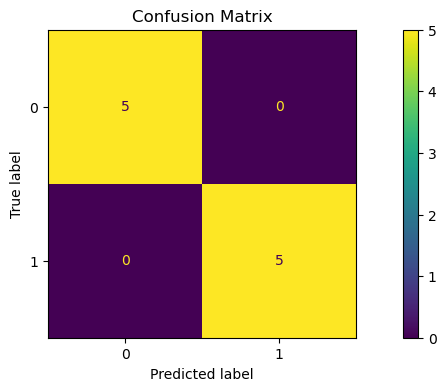

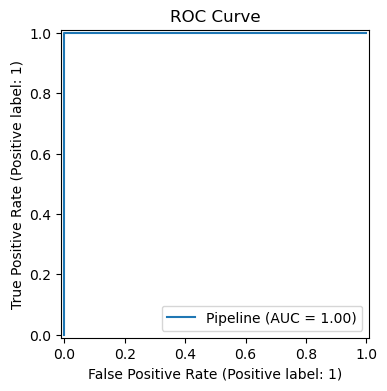

In [13]:
# Show the results
print_search_results(randforest_search, duration)

# Get the Best Model & Calculate Predicted Y and Evaluate
model_randforest = randforest_search.best_estimator_
# model_randforest = rf_model
y_pred = model_randforest.predict(X_test_transformed)
classification_metrics(model_randforest, X_test_transformed, y_test, y_pred)


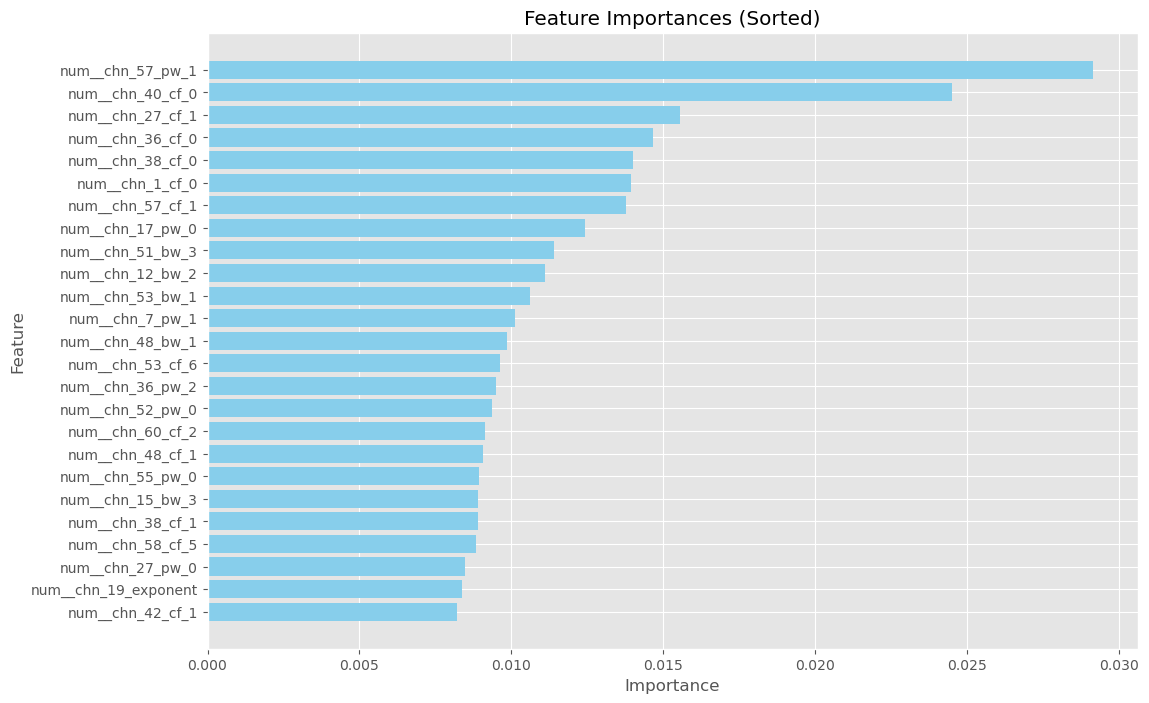

In [14]:
# Get feature importances
importances = model_randforest.named_steps['randomforestclassifier'].feature_importances_

# Map feature importances to feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
# Keep only the top 25 most important features
importance_df = importance_df.head(25)

# print(importance_df)

# Plot the feature importances with names horizontally
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances (Sorted)')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [15]:
# Save the model

file_path = os.path.join(ml_training_run_path, 'test_model.pkl')
container = (model_randforest)
with open(file_path, 'wb') as file:
    pickle.dump(container, file)
